# 서울 부동산 시장 분석 및 투자 전략 수립

## 자유주제: 금리 ~~및 정부 부동산 정책 변화~~가 서울 부동산 시장에 미치는 영향 분석
1. 금리 데이터 크롤링
    - 금리 데이터와 부동산 시장(거래량, 거래금액)과의 상관관계 분석
2. ~~주요 정부 부동산 정책 날짜 체크~~
    - ~~날짜 기준으로 잘라서 앞뒤 따로 분석(그래프 등)~~
3. ~~실무 인사이트 도출~~

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from IPython.display import display

warnings.filterwarnings('ignore')

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

df_sales = pd.read_csv('./data/sales_clean.csv')
df_sales['계약월'] = pd.to_datetime(df_sales['계약일'], format='%Y%m%d')


In [3]:
df_interest = pd.read_csv('./data/금리.csv')
df_interest['월'] = pd.to_datetime(df_interest['월'], format='%Y-%m')

monthly_stats = df_sales.groupby(['계약월']).agg({
    '거래금액': ['count', 'mean'],
    '평단가': 'mean'
}).reset_index()
monthly_stats.columns = ['계약월', '월별거래건수', '월평균거래금액', '월평균평단가']

# 월별 거래량, 평단가 변화율 계산
monthly_stats['월별거래량변화율'] = monthly_stats['월별거래건수'].pct_change()
monthly_stats['월별평단가변화율'] = monthly_stats['월평균평단가'].pct_change()

# 이동평균 / 이동표준편차
monthly_stats['이동평균'] = monthly_stats['월평균거래금액'].rolling(12, min_periods=1).mean()
monthly_stats['이동표준편차'] = monthly_stats['월평균거래금액'].rolling(12, min_periods=1).std()

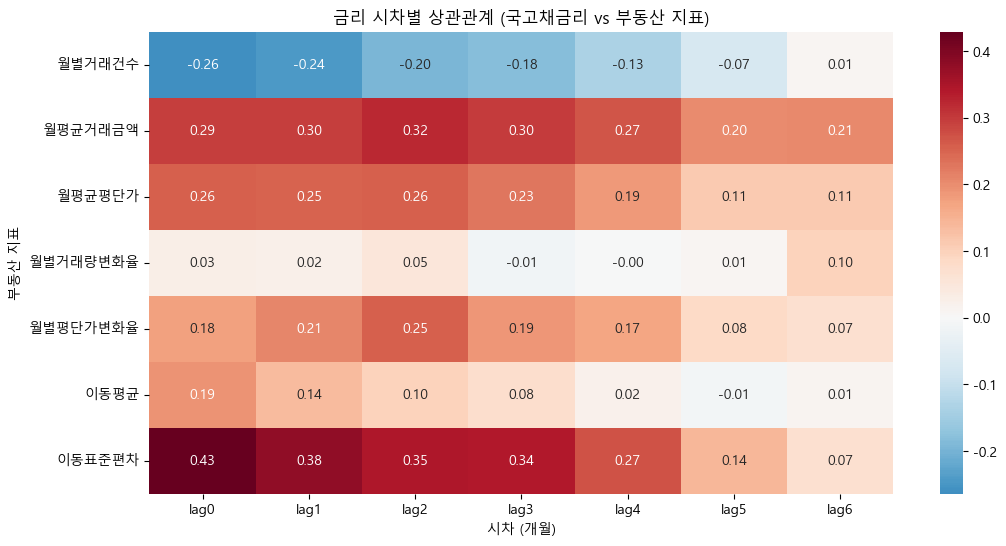

In [6]:
# 1. 컬럼명 통일 후 merge
df_interest = df_interest.rename(columns={'월': '계약월'})
df = pd.merge(monthly_stats, df_interest, on='계약월', how='inner')

# 2. 분석 대상 변수
target_vars = ['월별거래건수','월평균거래금액','월평균평단가',
               '월별거래량변화율','월별평단가변화율','이동평균','이동표준편차']

# 3. 시차 적용 후 상관계수 저장
max_lag = 6
corr_dict = {}

for lag in range(max_lag+1):
    df[f'금리_lag{lag}'] = df['국고채5년(평균)'].shift(lag)
    corr_values = []
    for col in target_vars:
        corr = df[[col, f'금리_lag{lag}']].corr().iloc[0,1]
        corr_values.append(corr)
    corr_dict[f'lag{lag}'] = corr_values

# 4. 데이터프레임 변환
corr_df = pd.DataFrame(corr_dict, index=target_vars)

# 5. 히트맵 시각화
plt.figure(figsize=(12,6))
sns.heatmap(
    corr_df,
    annot=True,
    fmt=".2f",
    cmap="RdBu_r",
    center=0
)
plt.title("금리 시차별 상관관계 (국고채금리 vs 부동산 지표)")
plt.xlabel("시차 (개월)")
plt.ylabel("부동산 지표")
plt.show()